In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import os
import time
import random
import pandas as pd
import numpy as np
import cv2
import torch
from tqdm.auto import tqdm
from PIL import Image
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data/train_solution_bounding_boxes (1).csv')
df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [5]:
# get image_id
df['image_id'] = df['image'].apply(lambda x: x.split('.')[0])
df['classes'] = 0
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0


In [6]:
# initializing configuration
img_h, img_w, num_channels = (380, 676, 3)
images_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data/training_images'

In [7]:
# converting the data points to YOLO format
df['x_center'] = (df['xmin'] + df['xmax']) / 2
df['y_center'] = (df['ymin'] + df['ymax']) / 2
df['w'] = df['xmax'] - df['xmin']
df['h'] = df['ymax'] - df['ymin']

In [8]:
# normalizing the values
df['x_center'] = df['x_center'] / img_w
df['y_center'] = df['y_center'] / img_h
df['w'] = df['w'] / img_w
df['h'] = df['h'] / img_h

In [9]:
df.head(2)

,image,xmin,ymin,xmax,ymax,image_id,classes,x_center,y_center,w,h
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547,vid_4_1000,0,0.450434,0.539817,0.068741,0.095238
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180,vid_4_10000,0,0.100217,0.557191,0.155572,0.129987


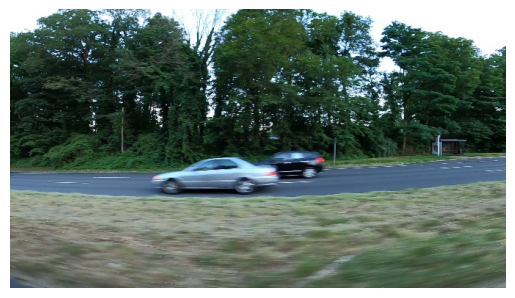

In [10]:
image = random.choice(df['image'])
image_path = os.path.join(images_folder, image)
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)
plt.show()

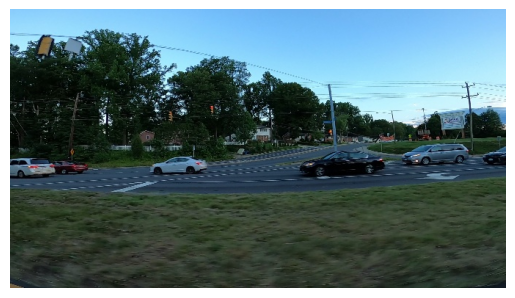

In [11]:
image = random.choice(df['image'])
image_path = os.path.join(images_folder, image)
img = Image.open(image_path)
plt.axis('off')
plt.imshow(img)
plt.show()

In [12]:
def draw_bounding_box(idx):
    image = cv2.imread(os.path.join(images_folder, df['image'][idx]))
    x_min = int(df['xmin'][idx])
    y_min = int(df['ymin'][idx])
    x_max = int(df['xmax'][idx])
    y_max = int(df['ymax'][idx])

    # draw the rectangle
    cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    # place the label above bounding boxes
    cv2.putText(image, 'car', (x_min, y_min-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    # display the image
    plt.axis('off')
    plt.imshow(image)
    plt.show()

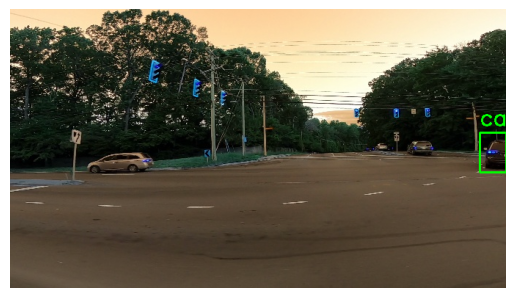

In [13]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

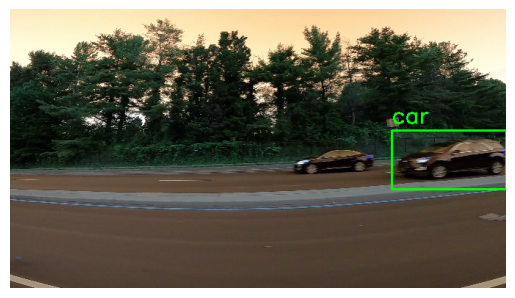

In [14]:
idx = random.randrange(0, len(df))
draw_bounding_box(idx)

In [15]:
annotations_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data/annotations/'

if not os.path.exists(annotations_folder):
    os.mkdir(annotations_folder)

In [16]:
annotations_dict = {}

# iterate through dataframe to consolidate bounding boxes for each image
for _, row in df.iterrows():
    image_file = row['image']
    class_label = int(row['classes'])
    x_center = row['x_center']
    y_center = row['y_center']
    w = row['w']
    h = row['h']

    # initialize list if image is not present in dicitionary
    if image_file not in annotations_dict:
        annotations_dict[image_file] = []

    # append annotations to the list
    annotations_dict[image_file].append(f"{class_label} {x_center} {y_center} {w} {h}")

# writing the annotations in text file
for image_file, annotations in annotations_dict.items():
    annotation_file = os.path.join(annotations_folder, os.path.splitext(image_file)[0] + '.txt')
    with open(annotation_file, 'w') as f:
        for annotation in annotations:
            f.write(annotation + '\n')

In [17]:
# splitting images for training and testing
from sklearn.model_selection import train_test_split
images = list(annotations_dict.keys())
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

In [18]:
# creating folders for train and test
train_images_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/train_images'
test_images_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images'
train_annotations_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/train_annotations'
test_annotations_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_annotations'

# creating directors for the above paths
import os
# Checking if the directory exists before creating it
if not os.path.exists('datasets'):
    os.mkdir('datasets')
if not os.path.exists(train_images_folder):
    os.mkdir(train_images_folder)
if not os.path.exists(test_images_folder):
    os.mkdir(test_images_folder)
if not os.path.exists(train_annotations_folder):
    os.mkdir(train_annotations_folder)
if not os.path.exists(test_annotations_folder):
    os.mkdir(test_annotations_folder)

In [19]:
# copy the files to the respective folder paths
def copy_files(images_list, image_src_folder, annotation_src_folder, image_dest_folder, annotation_dest_folder):
    for image_file in images_list:
        # path for source and destination
        src_image_path = os.path.join(image_src_folder, image_file)
        annotation_file = os.path.splitext(image_file)[0] + '.txt'
        src_annotations_path = os.path.join(annotation_src_folder, annotation_file)
        dest_image_path = os.path.join(image_dest_folder, image_file)
        dest_annotation_path = os.path.join(annotation_dest_folder, annotation_file)

        # copy images
        shutil.copy2(src_image_path,  dest_image_path)
        # copy annotations
        shutil.copy2(src_annotations_path, dest_annotation_path)

In [3]:
import os

images_folder = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data/training_images'
file_to_check = 'vid_4_4540.jpg'
file_path = os.path.join(images_folder, file_to_check)

if os.path.exists(file_path):
  print(f"File '{file_to_check}' exists at '{file_path}'")
else:
  print(f"File '{file_to_check}' does NOT exist at '{file_path}'")

File 'vid_4_4540.jpg' exists at '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data/training_images/vid_4_4540.jpg'


In [ ]:
copy_files(train_images, images_folder, annotations_folder, train_images_folder, train_annotations_folder)
copy_files(test_images, images_folder, annotations_folder, test_images_folder, test_annotations_folder)

In [5]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [36]:
#Already trained the model, no need to do so again
from ultralytics import YOLO
# load pretrained model
model = YOLO('yolov8n.yaml')

# define training parameters
model.train(data='/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data.yaml', epochs=50, batch=16, imgsz=676, workers=2)

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=676, save=True, save_period=-1, cache=False, device=None, workers=2, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cr

train: Scanning /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/train_images.cache... 283 images, 0 backgrounds, 1 corrupt: 100%|██████████| 284/284 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/train_images/vid_4_11880.jpg: ignoring corrupt image/label: cannot identify image file '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/train_images/vid_4_11880.jpg'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 704 train, 704 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.65G      4.733      5.453      4.268         26        704: 100%|██████████| 18/18 [00:06<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.77G      3.689      4.175      3.974         38        704: 100%|██████████| 18/18 [00:08<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


                   all         71        119          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.79G      3.126      3.479      3.421         21        704: 100%|██████████| 18/18 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.79G      2.691      2.793      2.882         30        704: 100%|██████████| 18/18 [00:06<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


                   all         71        119          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.79G      2.507      2.408      2.585         45        704: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.8G      2.395      2.177       2.44         27        704: 100%|██████████| 18/18 [00:06<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         71        119          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       2.8G      2.257      1.944      2.315         21        704: 100%|██████████| 18/18 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         71        119      0.329    0.00553    0.00264   0.000433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       2.8G      2.202      1.786      2.303         29        704: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.72it/s]

                   all         71        119      0.565      0.193      0.252      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       2.8G      2.095      1.677      2.186         30        704: 100%|██████████| 18/18 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.75it/s]

                   all         71        119      0.733      0.521      0.627      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       2.8G      2.064      1.547      2.113         28        704: 100%|██████████| 18/18 [00:07<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.08it/s]

                   all         71        119      0.851      0.681      0.843      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       2.8G      1.956      1.447      2.055         29        704: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.98it/s]

                   all         71        119      0.774      0.765      0.816      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       2.8G      1.931      1.393      1.965         34        704: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         71        119       0.81      0.753       0.83        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.82G      1.809      1.248      1.903         40        704: 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         71        119      0.899       0.75      0.871       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.82G      1.827      1.253       1.95         38        704: 100%|██████████| 18/18 [00:07<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         71        119      0.882      0.773      0.868      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.84G      1.789      1.194      1.879         41        704: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.44it/s]

                   all         71        119       0.93      0.866      0.931      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.84G      1.701      1.145      1.821         39        704: 100%|██████████| 18/18 [00:06<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]

                   all         71        119      0.944      0.857      0.929      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.85G      1.703      1.132      1.844         36        704: 100%|██████████| 18/18 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.12it/s]

                   all         71        119      0.925      0.891      0.944      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.85G      1.658      1.106      1.798         42        704: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

                   all         71        119      0.939      0.882      0.947       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.85G      1.674      1.079      1.831         44        704: 100%|██████████| 18/18 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.04it/s]

                   all         71        119      0.902      0.857      0.924      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.85G      1.594      1.009      1.706         28        704: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         71        119      0.946      0.888      0.933      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.85G      1.573     0.9892      1.747         35        704: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]

                   all         71        119      0.964      0.907      0.957      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.87G      1.546      0.967      1.675         31        704: 100%|██████████| 18/18 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.72it/s]

                   all         71        119      0.976      0.874      0.952       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.87G      1.501     0.9128      1.661         25        704: 100%|██████████| 18/18 [00:07<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.77it/s]

                   all         71        119      0.942      0.933      0.957      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.87G      1.582     0.9293      1.733         22        704: 100%|██████████| 18/18 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.75it/s]

                   all         71        119      0.924      0.915      0.939      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.87G      1.546     0.9453      1.652         42        704: 100%|██████████| 18/18 [00:06<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]

                   all         71        119      0.943      0.916      0.952      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.87G      1.516     0.9162      1.616         33        704: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         71        119      0.963      0.871      0.944      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.87G      1.494     0.8624      1.661         37        704: 100%|██████████| 18/18 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.14it/s]

                   all         71        119      0.956       0.91      0.957      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.87G      1.513     0.8846      1.666         27        704: 100%|██████████| 18/18 [00:06<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]

                   all         71        119      0.973      0.908      0.964      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.87G      1.492     0.8602      1.613         26        704: 100%|██████████| 18/18 [00:05<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         71        119      0.905      0.916      0.948       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.87G      1.495     0.8483      1.611         29        704: 100%|██████████| 18/18 [00:09<00:00,  1.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         71        119       0.94      0.941      0.962      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.87G      1.489     0.8292      1.569         49        704: 100%|██████████| 18/18 [00:05<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.82it/s]

                   all         71        119       0.97      0.908      0.963      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.87G      1.479     0.8195      1.604         39        704: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         71        119      0.947      0.933      0.958      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.87G      1.456     0.7875      1.547         32        704: 100%|██████████| 18/18 [00:05<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.80it/s]

                   all         71        119      0.895      0.926      0.956      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.87G       1.43     0.8131      1.575         32        704: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         71        119      0.957      0.882      0.948      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.87G      1.419     0.7975      1.565         20        704: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.95it/s]

                   all         71        119      0.939      0.908      0.951      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.87G      1.414     0.7943      1.511         31        704: 100%|██████████| 18/18 [00:07<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         71        119      0.963      0.899      0.937      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.87G      1.395      0.744      1.528         38        704: 100%|██████████| 18/18 [00:05<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]

                   all         71        119      0.979      0.908      0.952      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.87G      1.415     0.7608      1.533         38        704: 100%|██████████| 18/18 [00:06<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.16it/s]

                   all         71        119      0.957      0.946      0.967      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.87G      1.353      0.736      1.513         36        704: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]

                   all         71        119      0.991      0.898      0.967      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.87G        1.4     0.7384      1.538         22        704: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         71        119       0.98      0.899       0.96      0.593


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.87G      1.368     0.8226      1.592         19        704: 100%|██████████| 18/18 [00:08<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         71        119      0.955      0.899      0.956      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.87G      1.313     0.7857      1.549         12        704: 100%|██████████| 18/18 [00:05<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

                   all         71        119      0.963      0.884      0.967      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.87G      1.333     0.7517      1.543         20        704: 100%|██████████| 18/18 [00:06<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.20it/s]

                   all         71        119      0.956      0.914       0.95      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.87G      1.306     0.7485      1.542         16        704: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.42it/s]

                   all         71        119      0.963      0.908      0.954      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.88G      1.291     0.7317      1.534         20        704: 100%|██████████| 18/18 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.94it/s]

                   all         71        119      0.963      0.908      0.965       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.88G      1.282     0.7206      1.534         19        704: 100%|██████████| 18/18 [00:06<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.02it/s]

                   all         71        119       0.98      0.899      0.966       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.9G       1.25     0.7107      1.523         23        704: 100%|██████████| 18/18 [00:05<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.70it/s]

                   all         71        119      0.978      0.899      0.959      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.9G       1.26      0.708      1.482         19        704: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.31it/s]

                   all         71        119       0.95      0.924      0.966      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.92G      1.269     0.7013      1.483         17        704: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.62it/s]

                   all         71        119      0.982      0.897      0.967      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.92G      1.248      0.699      1.469         17        704: 100%|██████████| 18/18 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.83it/s]

                   all         71        119      0.979      0.899      0.967       0.62



50 epochs completed in 0.117 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 6.2MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


                   all         71        119      0.956      0.923      0.959      0.621
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7bac79609190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [40]:
from ultralytics import YOLO

# Saving the entire model (architecture + weights + metadata)
model.save('/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/trainedmodel.pt')

In [54]:
from ultralytics import YOLO

# Load the full model(petrained on our dataset)
model = YOLO('/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/trainedmodel.pt')
model.eval()

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [51]:
metrics = model.val(data='/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/data.yaml')  # Provide path to data.yaml

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


                   all         71        119      0.978      0.899      0.959      0.621
Speed: 4.7ms preprocess, 4.3ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/val3



image 1/1 /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_10020.jpg: 416x704 1 car, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 704)


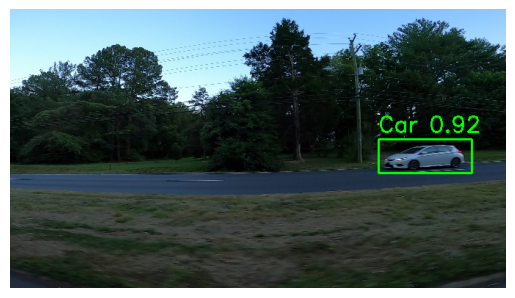

In [55]:
# process the results
image_path = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_10020.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()


image 1/1 /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_26360.jpg: 416x704 4 cars, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 704)


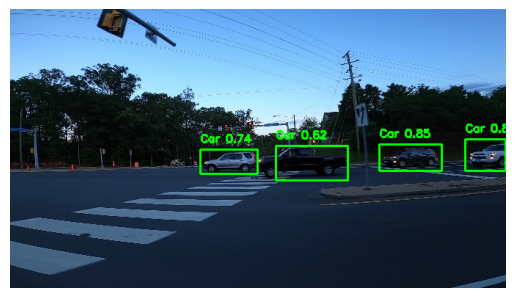

In [53]:
# process the results
image_path = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_26360.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()


image 1/1 /content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_1040.jpg: 416x704 1 car, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 704)


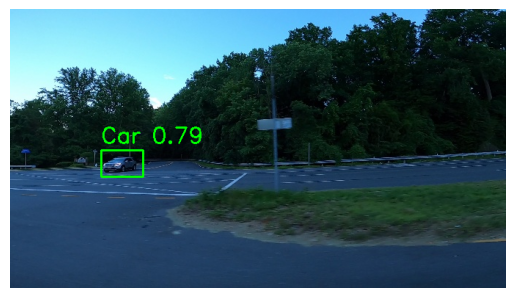

In [56]:
# process the results
image_path = '/content/drive/MyDrive/Academics/CustomObject/CustomObjectDetection/test_images/vid_4_1040.jpg'
results = model(image_path)
image = cv2.imread(image_path)
for result in results:
    # loop through the detected objects
    for detection in result.boxes:
        x_min, y_min, x_max, y_max = detection.xyxy[0]
        confidence = round(float(detection.conf[0]), 2)
        class_id = int(detection.cls[0])

        # draw bouding box
        cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

        # write label
        label = f"Car {confidence}"
        cv2.putText(image, label, (int(x_min), int(y_min)-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

# convert the image to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb)
plt.axis('off')
plt.show()